## Introduction

Trending topics detection and trend detection is an active area of research and choosing best strategy is task dependent. It could start from simple word count techniques, topic modeling and statstical methods for trend detection. Again it all depends on purpose and nature of the problem. For simplicity and given the time I have for the task. I will choose twitter dataset and deal with trend detection through hashtags as reperesentative to twitter treding topics, so I will assume that trending topics are somewhat represented by trending hashtags. I will also do topic modeling using LDA on tweets. This task is more of an EDA task for me given the generality of the task and time restrictions I have.

## Dataset

The covid19 tweets dataset contain tweets from around 17th to 28th or March. It can be downloaded from here:https://www.kaggle.com/smid80/coronavirus-covid19-tweets

## Loading Required Libraries

Here we will load the libraries we will use throughout the code.

In [70]:
#Python imports
import io
import random
import string
import warnings
import pandas as pd
import numpy as np
import warnings
import re
import os
warnings.filterwarnings('ignore')

#Nltk imports
import nltk
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.sentiment.util import *


#sklearn imports
from sklearn.feature_extraction.text import CountVectorizer


#Visualization
from matplotlib import pyplot as plt
import seaborn as sns

## Helper Functions

Here we will define the functions we will use throughout the code

In [15]:
#Extract twitter handles mentioned in the tweet
def get_mentions(tweet):
    return re.findall('(?<!RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

In [16]:
#Extract Hashtags
def get_hashtags(tweet):
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

In [110]:
#Stems words using porter stemmer leaving hashtags
def stem_tweet(tweet):
    tweet_token_list = [porter_stemmer(word) if '#' not in word else word for word in tweet.split(' ')]
    tweet = ' '.join(tweet_token_list)
    return tweet

In [111]:
#Get diagonal and lower triangular pairs of correlation matrix
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

In [112]:
#Get top absolute correlations in a correlation matrix
def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

## Loading Tweets Data

We read all the tweets from different files and concatenate them into one dataframe

In [22]:
data_directory = 'coronavirus-covid19-tweets/tweets'
tweets_list = []
for file in sorted(os.listdir(data_directory)):
    tweets_list.append(pd.read_csv(data_directory + '/' + file, lineterminator = '\n'))
#     print(file)

df = pd.concat(tweets_list)
df.tail()


,status_id,user_id,created_at,screen_name,text,source,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,...,retweet_count,country_code,place_full_name,place_type,followers_count,friends_count,account_lang,account_created_at,verified,lang
582050,1244051643605430277,50997451,2020-03-28T23:59:59Z,ClaudiaWebbe,See here 👇🏾specialist nurses from Cuba arrive ...,Twitter for iPhone,1.243929e+18,50997451.0,ClaudiaWebbe,True,...,24,NaN,NaN,NaN,17920,6852,NaN,2009-06-26T09:53:43Z,True,en
582051,1244051643802542085,1243929924685172738,2020-03-28T23:59:59Z,AdorkableMel,All day of #selfisolating on the couch binging...,Twitter for Android,NaN,NaN,NaN,False,...,0,NaN,NaN,NaN,2,15,NaN,2020-03-28T15:56:35Z,False,en
582052,1244051642569252866,43339954,2020-03-28T23:59:59Z,MrPartyyyHardy,It’s about that time of the day that I start s...,Twitter for iPhone,NaN,NaN,NaN,False,...,0,US,"Torrance, CA",city,596,465,NaN,2009-05-29T14:33:24Z,False,en
582053,1244051642179358724,580195664,2020-03-28T23:59:59Z,1lifesha2live,"Smoked Salmon,Carrots,Corn bread,Rice n beans,...",Instagram,NaN,NaN,NaN,False,...,0,NaN,NaN,NaN,900,444,NaN,2012-05-14T20:08:34Z,False,en
582054,1244051641466322944,327206200,2020-03-28T23:59:59Z,YorukIsik,The missing six weeks: how Trump failed the bi...,Twitter for iPhone,NaN,NaN,NaN,False,...,0,NaN,NaN,NaN,32732,2666,NaN,2011-07-01T05:04:21Z,True,en


## Data Cleaning and Filtering

Some data preprocessing and filtering is done in this section of the code

In [23]:
#Remove tweets with missing dates
df = df[df['created_at'].notna()]

#Remove tweets with missing text
df = df[df['text'].notna()]

#Refmove URLS
df['text'] = df['text'].apply(lambda x: re.sub(r"https\S+", "", str(x)))
df['text'].head()

0    HOY | 20H00\n@CataAndramuno, ministra de @Salu...
1    石家庄的一个小孩。可惜啊！\n\n#冠状病毒爆发 #冠状病毒 #肺炎 #病毒 #武汉肺炎追踪...
2    During a health scare like the #CoronavirusOut...
3    @Twitter please update reporting to include fa...
4    Germ Guardian Pluggable Air Purifier &amp; San...
Name: text, dtype: object

In [24]:
#Keep only English characters
df['text'] = df['text'].apply(lambda x: re.sub("([^\x00-\x7F])+"," ", str(x)))
df['text'].head()

0    HOY | 20H00\n@CataAndramuno, ministra de @Salu...
1     \n\n#  #  #  #  #  #  #  #  #  #  #  #Coronav...
2    During a health scare like the #CoronavirusOut...
3    @Twitter please update reporting to include fa...
4    Germ Guardian Pluggable Air Purifier &amp; San...
Name: text, dtype: object

In [25]:
#Remove punctuations except hastags and mentions
#print(punctuations)
punctuations = "!\"$%&'()*+,-./:;<=>?[\]^_`{|}~"
df['text'] = df['text'].apply(lambda x: x.translate(str.maketrans('', '', punctuations)))
df['text'].head()

0    HOY  20H00\n@CataAndramuno ministra de @SaludE...
1     \n\n#  #  #  #  #  #  #  #  #  #  #  #Coronav...
2    During a health scare like the #CoronavirusOut...
3    @Twitter please update reporting to include fa...
4    Germ Guardian Pluggable Air Purifier amp Sanit...
Name: text, dtype: object

In [26]:
#Text to lower case
df['text'] = df['text'].apply(lambda x: x.lower())
df['text'].head()

0    hoy  20h00\n@cataandramuno ministra de @salude...
1     \n\n#  #  #  #  #  #  #  #  #  #  #  #coronav...
2    during a health scare like the #coronavirusout...
3    @twitter please update reporting to include fa...
4    germ guardian pluggable air purifier amp sanit...
Name: text, dtype: object

## Eploratory Data Analysis

In [113]:
#the number of tweets we have
print("Total number of tweets in our dataframe: ",len(df))

Total number of tweets in our dataframe:  6788604


In [28]:
#Dataframe Columns
print(df.columns.values)

['status_id' 'user_id' 'created_at' 'screen_name' 'text' 'source'
 'reply_to_status_id' 'reply_to_user_id' 'reply_to_screen_name' 'is_quote'
 'is_retweet' 'favourites_count' 'retweet_count' 'country_code'
 'place_full_name' 'place_type' 'followers_count' 'friends_count'
 'account_lang' 'account_created_at' 'verified' 'lang']


In [29]:
#Most retweeted tweets
df.sort_values(by=['retweet_count'], ascending=False).loc[:,["screen_name","text","retweet_count"]].head(10)


,screen_name,text,retweet_count
792479,NicholsUprising,sicily has figured out this whole selfisolatio...,149747
696083,silv24,this is the face of someone who just spent 9 h...,79827
102891,bts_love_myself,#covid19 \n\n \n\n\n\...,74065
100892,maleedus,so theres a covid19 quarantine playlist on spo...,61954
68222,InternetXp1orer,breaking china has reported the outbreak of a ...,57207
333667,WHO,breaking \n\nwe have therefore made the ass...,56319
353516,Sxrv_X,who #covid19 pandemic 3 \n\...,55682
165411,GhaydaaSamaan,earth is taking a break a much needed break\n\...,53983
414365,weijia,this morning a white house official referred t...,51790
122141,Natthalam,2 5 12 # 19 #covid19,51624


Since the data is from twitter, our domain knowledge tells us that hashtags are a good indicator of trending topics within our datasets. So, we will extract hashtags and try to see the top most trending hashtags in our dataset.

In [30]:
#Extract hastags
df['hashtags'] = df.text.apply(get_hashtags)
df['hashtags'].head()

0                                           [#covid19]
1    [#coronavirusoutbreak, #coronavirus, #china, #...
2                               [#coronavirusoutbreak]
3    [#covid19, #covid19usa, #caronavirusoutbreak, ...
4    [#coronavirus, #corona, #virus, #coronavirusou...
Name: hashtags, dtype: object

In [31]:
#Extract rows with none empty hashtags
hashtagsListDF = df.loc[
                       df.hashtags.apply(
                           lambda hashtags_list: hashtags_list !=[]
                       ),['hashtags']]

In [33]:
hashtagsListDF.head()

,hashtags
0,[#covid19]
1,"[#coronavirusoutbreak, #coronavirus, #china, #..."
2,[#coronavirusoutbreak]
3,"[#covid19, #covid19usa, #caronavirusoutbreak, ..."
4,"[#coronavirus, #corona, #virus, #coronavirusou..."


In [32]:
#One hashtag per row
flattenedHashtagsDF = pd.DataFrame(
    [hashtag for hashtags_list in hashtagsListDF.hashtags
    for hashtag in hashtags_list],
    columns=['hashtag'])


In [34]:
flattenedHashtagsDF.head()

,hashtag
0,#covid19
1,#coronavirusoutbreak
2,#coronavirus
3,#china
4,#wuhan


In [114]:
#Number of unique hashtags
print("The number of unique hashtags: ",flattenedHashtagsDF['hashtag'].unique().size)

The number of unique hashtags:  1356482


In [37]:
#The popular hashtags dataframe has the hashtags sorted by the number of times they appear
popularHashtagsDF = flattenedHashtagsDF.groupby('hashtag').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)


In [40]:
popularHashtagsDF.head(30)

,hashtag,counts
0,#covid19,6852415
1,#coronavirus,6503527
2,#coronaviruspandemic,829700
3,#covid,560764
4,#coronavirusoutbreak,549355
5,#covid2019,326755
6,#corona,261338
7,#coronavirusupdate,207652
8,#stayhome,160107
9,#stayathome,146386


We can see that the topics talked about carry 3 different nature. The first being the technical talk about the covid19 pandemic, flatenning the curve and such. The other one is of political nature in the hashtags #trump and china. Lastly the social part in stay at home, stay safe, social distancing and quarantine life.

In [41]:
print("The number of hashtags: ", len(popularHashtagsDF))

The number of hashtags:  1356482


Now, we have gotten some interesting insights but we want to get more deeper insights. We have around 1.3 million hashtags, so we won't be doing a deeper analysis on all of them. We will try to analyze the correlation between top trending tweets appearing more than 10,000 times.

In [45]:
min_appearance = 10000
print("The number of hashtags appearing more than ",min_appearance," times: ", len(popularHashtagsDF[popularHashtagsDF.counts>=min_appearance]))

The number of hashtags appearing more than  10000  times:  205


In [50]:
# take hashtags which appear at least this amount of times
min_appearance = 10000
# find popular hashtags - make into python set for efficiency
popularHashtagsSet = set(popularHashtagsDF[
                           popularHashtagsDF.counts>=min_appearance
                           ]['hashtag'])


In [54]:
# make a new column with only the popular hashtags
hashtagsListDF['popular_hashtags'] = hashtagsListDF.hashtags.apply(
            lambda hashtag_list: [hashtag for hashtag in hashtag_list
                                  if hashtag in popularHashtagsSet])
# drop rows without popular hashtag
popularHashtagsListDF = hashtagsListDF.loc[
            hashtagsListDF.popular_hashtags.apply(lambda hashtag_list: hashtag_list !=[])]


In [55]:
#Long to wide format
hashtagVectorDF = popularHashtagsListDF.loc[:, ['popular_hashtags']]

for hashtag in popularHashtagsSet:
    # make columns to encode presence of hashtags
    hashtagVectorDF['{}'.format(hashtag)] = hashtagVectorDF.popular_hashtags.apply(
        lambda hashtag_list: int(hashtag in hashtag_list))


In [56]:
hashtagVectorDF.head()

,popular_hashtags,#coronaturkiye,#virus,#coronavirusoutbreak,#macron20h,#shelterinplace,#staythefhome,#soka,#coronavirusbrasil,#covid19mx,...,#staysafestayhome,#breaking,#chloroquine,#coronakrise,#chinavirus,#coronaupdatesinindia,#trumppandemic,#who,#love,#italy
0,[#covid19],0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"[#coronavirusoutbreak, #coronavirus, #china, #...",0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,[#coronavirusoutbreak],0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"[#covid19, #covid19usa, #coronavirus, #covid20...",0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"[#coronavirus, #corona, #virus, #coronavirusou...",0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
hashtag_matrix = hashtagVectorDF.drop('popular_hashtags', axis=1)

In [59]:
#calculate the correlation matrix
correlations = hashtag_matrix.corr()

In [60]:
print(correlations.shape)

(205, 205)


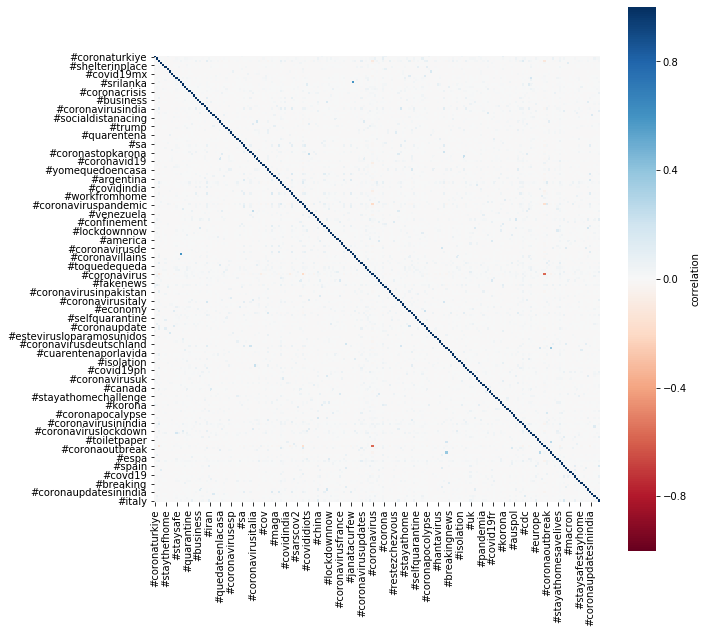

In [61]:
# plot the correlation matrix
plt.figure(figsize=(10,10))
sns.heatmap(correlations,
    cmap='RdBu',
    vmin=-1,
    vmax=1,
    square = True,
    cbar_kws={'label':'correlation'})
plt.show()

###### As we can see it's very difficult to interpret the correlation graph

We will try to get the top 50 correlated tweets in a more interpretable format.

In [115]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(hashtag_matrix, 50))


Top Absolute Correlations
#srilanka               #lka                         0.593634
#coronavirus            #covid19                     0.570993
#qu                     #activadosporlasalud         0.376790
#prevenci               #activadosporlasalud         0.275460
#coronavirusitalia      #covid19italia               0.254462
#cuarentenaobligatoria  #cuarentenatotal             0.232349
#coronalockdown         #coronaupdate                0.222026
#coronastopkarona       #coronavirusoutbreakindia    0.204331
#coronavirusde          #coronavirusdeutschland      0.193506
#coronaviruspandemic    #coronavirus                 0.190235
#staysafe               #stayhome                    0.181882
#qu                     #prevenci                    0.181513
#covid2019india         #coronavirusoutbreakindia    0.180177
#quedateenlacasa        #cuarentenanacional          0.178804
#wuhanvirus             #chinavirus                  0.175863
#china                  #wuhan              

It's intersting here also how there are technical terms that correlate with each other like coronavirus and covid19. There is talk about WHO and CDC which are correlated together. There are some talk about curfew and corona virus in India. It's interesting though to see the political talk and conflict detected as well. Like trumpvirus, trumppandemic, chinavirus and wuhanvirus. The social life part is also present in stay at home challenge and quarantine life.

## Topic Modeling

Now we tried to get insights into trending topics using only the hashtags without looking at the actual terms mentioned in the tweet itself. Now we will do a different approach. We will try to extract the top trending topics using LDA. 

### Filtering

Since topic modeling is very language related, we will do an extra step here that we didn't do when analyzing the hashtags. We will do topic modeling for tweets only in English. We will also do the modeling in tweets retweeted for more than 10 times due to the huge size of the dataset.

In [95]:
#Select only english tweets
df = df[df["lang"] == 'en']

In [96]:
#Tweets with minimum of 10 retweets, this is mainly to meet memory restrictions
min_retweets = 10
tweetsDF = df[df["retweet_count"] > min_retweets]

## Stemming

From the trials I made, stemming seemed to yield a better result so I will perform stemming

In [98]:
porter_stemmer = PorterStemmer().stem

In [102]:
tweetsDF['text'] = tweetsDF.text.apply(stem_tweet)


### LDA

In [103]:
# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(max_df=0.8, min_df=25, token_pattern='\w+|\$[\d\.]+|\S+', stop_words = 'english')

# apply transformation
tf = vectorizer.fit_transform(tweetsDF['text'])

# will be used to tell LDA which words correspond to which columns
tf_feature_names = vectorizer.get_feature_names()


In [104]:
# Set the number of topics to 10
number_of_topics = 10

model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)

In [105]:
model.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [106]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [109]:
no_top_words = 20
display_topics(model, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights
0,#coronavirus,9617.2,#covid19,21314.3,#coronavirus,21766.9,#covid19,15802.5,#coronavirus,11236.5,#covid19,16154.7,#covid19,21371.4,#covid19,11766.3,case,29730.1,test,22977.4
1,#covid19,7230.1,#coronavirus,14132.2,thi,12501.1,amp,9437.4,#covid19,10163.3,#coronavirus,12482.5,#coronavirus,11485.8,#coronavirus,11217.0,#covid19,15998.4,#coronavirus,11690.7
2,fight,5499.1,thi,13744.5,#covid19,11330.1,spread,6326.7,hospit,6451.2,close,7878.0,thi,7129.9,thi,10323.6,#coronavirus,14989.5,#covid19,9836.9
3,thi,4844.8,peopl,12988.2,trump,10286.8,health,5985.3,patient,6360.8,school,5383.3,inform,6036.8,stay,7932.4,new,12642.4,posit,9077.3
4,#coronaviruspandemic,4139.8,t,7556.4,s,7860.1,#coronavirus,5937.7,medic,3601.3,order,4721.6,amp,4814.4,work,6855.2,death,12176.8,ha,5187.5
5,amp,3477.8,social,6363.2,wa,5908.3,hand,3691.7,china,3577.7,amp,4541.2,share,4792.7,home,6359.5,confirm,8522.6,#coronavirusoutbreak,4733.7
6,world,3361.2,need,5706.6,hi,5840.6,measur,3645.3,ha,3384.7,servic,3784.2,pleas,4687.0,amp,5505.5,total,7408.1,quarantin,4214.6
7,pm,3218.7,amp,5659.1,amp,5019.1,prevent,3373.9,doctor,2792.7,ha,3542.2,updat,4668.1,time,4911.1,number,7028.1,#coronaviruspandemic,2784.4
8,lockdown,3039.8,distanc,5646.0,ha,4806.2,public,2956.0,treat,2125.8,worker,3518.7,help,4562.4,help,4646.4,report,6879.1,travel,2370.7
9,peopl,2940.3,s,5387.2,@realdonaldtrump,4390.1,countri,2687.0,wa,2101.3,state,3497.8,question,2776.6,safe,4473.7,ha,5697.9,peopl,1911.1


I think the findings from LDA are quiet interesting. I will try to interpret the topics as follows:


Topic 0: is mostly about the outbreak in india. We can notice this by how many people mention india's PM Modi san. Also the word india is a top word.

Topic 1: is mostly about staying at home and asking people to stay at home and avoid the risk.

Topic 2: is mostly about american politics related to the united states president donald trump and the coronavirus pandemic.

Topic 3: is mostly related to protection against pandemic and countries response to protect against pandemic and also WHO.

Topic 4: is mostly related to hospitals, medical staff, doctors, treatments vaccines and the pandemic.

Topic 5: is mostly about how the pandemic is affecting schools, workers, food supplies and government decisions.

Topic 6: is mostly about news and updates regarding the pandemic.

Topic 7: is about staying at home, staying safe and supporting workers who need support.

Topic 8: is more about daily reports of deaths, infections and such.

Topic 9: is mostly about testing, self isolation, quarantine after travel. We can see also that india is one of the top words, so it probably has some context of those words in india.

## Conclusion

In this report we tried to extract trending topics related to coronavirus from a twitter dataset containing tweets from March 17th to 28th related to coronavirus. I tried two approaches. The first is representing tweets as hashtags. While this approach is good at giving you a general idea of the topics talked about on twitter. It's too general and ignores other words and mentions which are also very important for twitter. For that we use the other method which is LDA which shows to give us a much better idea when tuned correctly to the problem.